<a href="https://colab.research.google.com/github/GurashishJuneja/MMAI831-Finance/blob/main/Finance_Assignment_3_Team_Broadview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from ast import increment_lineno
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,8)

%matplotlib inline
from statsmodels.tsa.stattools import coint

import seaborn

try:
  import statsmodels
  print("module 'statsmodels' is installed")

except ModuleNotFoundError:

  print("module 'statsmodels' is not installed")

  !pip install statsmodels

from statsmodels.tsa.stattools import coint

try:
  import yfinance
  print("module 'yfinance' is installed")

except ModuleNotFoundError:

  print("module 'yfinance' is not installed")

  !pip install yfinance

import yfinance as yf




module 'statsmodels' is installed
module 'yfinance' is installed


Question 1:

Choose 10 stocks that are in the same industry and identify a part that has the highest correlation(do not use the sames ones in the example from class).

a. Implement the pair trading strategy (you can use any time period). Choose different values for k and copare the performance( Pnl = Profit and Loss)

b. Try the strategy to the pair that have the second highest correlation.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

try:
    import statsmodels
    print("module 'statsmodels' is installed")
except ModuleNotFoundError:
    print("module 'statsmodels' is not installed")
    !pip install statsmodels

from statsmodels.tsa.stattools import coint

try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance

import yfinance as yf

module 'statsmodels' is installed
module 'yfinance' is installed


In [ ]:
# Loading 10 banks on the S&P500
tickers = ["JPM", "BAC", "C", "WFC", "GS", "MS", "USB", "TFC", "PNC", "COF"]

# Assumption: given we have not been provided with a time frame we will assume the following start and end date
start_date = "2010-01-01"
end_date = "2021-12-01"

data = yf.download(tickers, start_date, end_date)["Adj Close"].dropna()


[*********************100%***********************]  10 of 10 completed


In [ ]:
data.head()

,BAC,C,COF,GS,JPM,MS,PNC,TFC,USB,WFC
Date,,,,,,,,,,
2010-01-04,12.977035,27.558561,31.881001,138.805969,30.073067,23.578484,37.446907,16.841188,15.812429,19.222216
2010-01-05,13.398852,28.612263,33.138260,141.259979,30.655584,24.440462,37.824791,17.082619,16.213272,19.749912
2010-01-06,13.555996,29.503868,33.317875,139.752243,30.824034,24.753216,37.824791,17.443567,16.386047,19.778051
2010-01-07,14.002625,29.584921,34.967033,142.487045,31.434620,25.111727,39.875240,18.145775,16.703957,20.495720
2010-01-08,13.878562,29.098589,34.664951,139.792358,31.357420,24.600647,39.980202,17.942327,16.731604,20.305744


In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.02:   #we choose p-value level at 2%
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('COF', 'GS')]


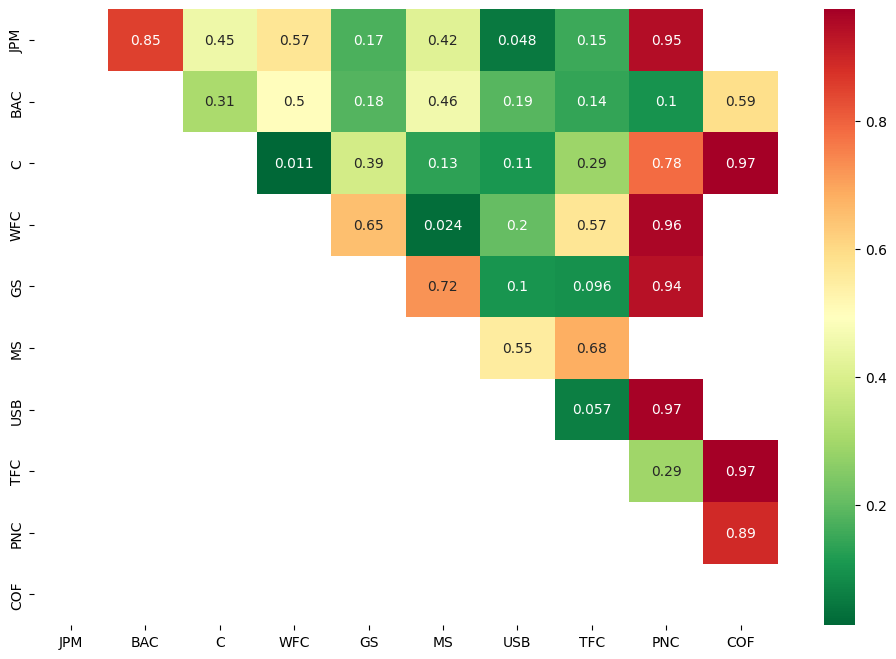

Pair with highest cointegration: ('COF', 'GS')


In [ ]:
pvalues, pairs = find_cointegrated_pairs(data)
print(pairs)

# Sort the pairs based on the p-values in ascending order
pairs.sort(key=lambda x: pvalues[tickers.index(x[0]), tickers.index(x[1])])

# Get the pair with the highest cointegration (lowest p-value)
highest_correlation_pair = pairs[0]

sns_plot = seaborn.heatmap(pvalues, xticklabels=tickers,
                           yticklabels=tickers, cmap="RdYlGn_r", annot=True,
                           mask=(pvalues >= 0.98))

fig = sns_plot.get_figure()
fig.savefig("correlation.jpg")
plt.show()

print("Pair with highest cointegration:", highest_correlation_pair)

Selecting COF and GS tickers

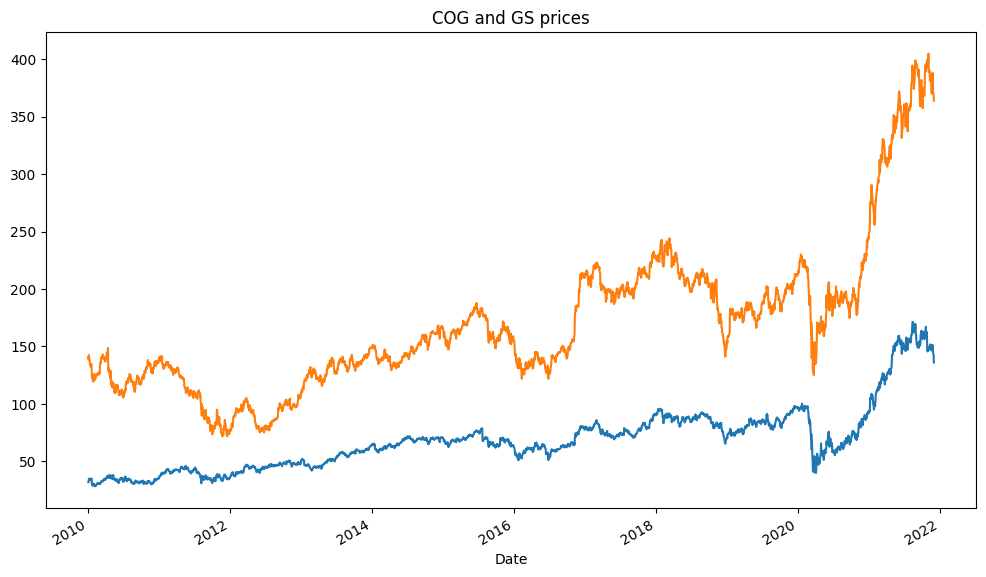

In [ ]:
symbol1_prices = data["COF"]
symbol2_prices = data["GS"]

plt.title("COG and GS prices")

symbol1_prices.plot(figsize=(12,7))

symbol2_prices.plot()

plt.legend

plt.savefig("COF + GS.jpg")

plt.show()

Defining the Z-score

0.011424051220246744


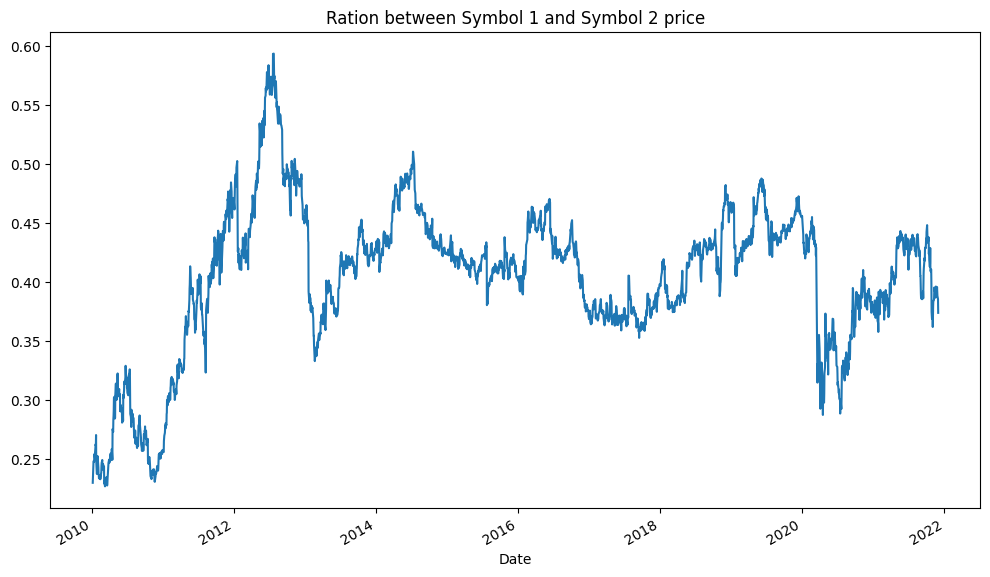

In [ ]:
def zscore(series):
  return(series - series.mean()) / np.std(series)

score, pvalue, _ = coint(symbol1_prices, symbol2_prices)

print(pvalue)

ratios = symbol1_prices/symbol2_prices

plt.title("Ration between Symbol 1 and Symbol 2 price")

ratios.plot(figsize =(12,7))

plt.show()

In [ ]:
z_scores = zscore(ratios)

In [ ]:
#Definfining the threshold "K"

k = 1.5

Identify the buy/sell signals

In [ ]:
# Generate buy and sell signals
symbol1_buy = pd.Series(0, index=symbol1_prices.index)
symbol1_sell = pd.Series(0, index=symbol1_prices.index)
symbol2_buy = pd.Series(0, index=symbol2_prices.index)
symbol2_sell = pd.Series(0, index=symbol2_prices.index)

In [ ]:
symbol1_buy[z_scores > k] = 1
symbol1_sell[z_scores < -k] = 1
symbol2_buy[z_scores < -k] = 1
symbol2_sell[z_scores > k] = 1

In [ ]:
# Calculate the positions for Symbol 1 and Symbol 2
symbol1_positions = symbol1_buy - symbol1_sell
symbol2_positions = symbol2_buy - symbol2_sell

In [ ]:
# Calculate the PnL for each trading position
symbol1_pnl = symbol1_positions.shift(1) * (symbol1_prices - symbol1_prices.shift(1))
symbol2_pnl = symbol2_positions.shift(1) * (symbol2_prices - symbol2_prices.shift(1))

# Calculate the total PnL
total_pnl = symbol1_pnl + symbol2_pnl

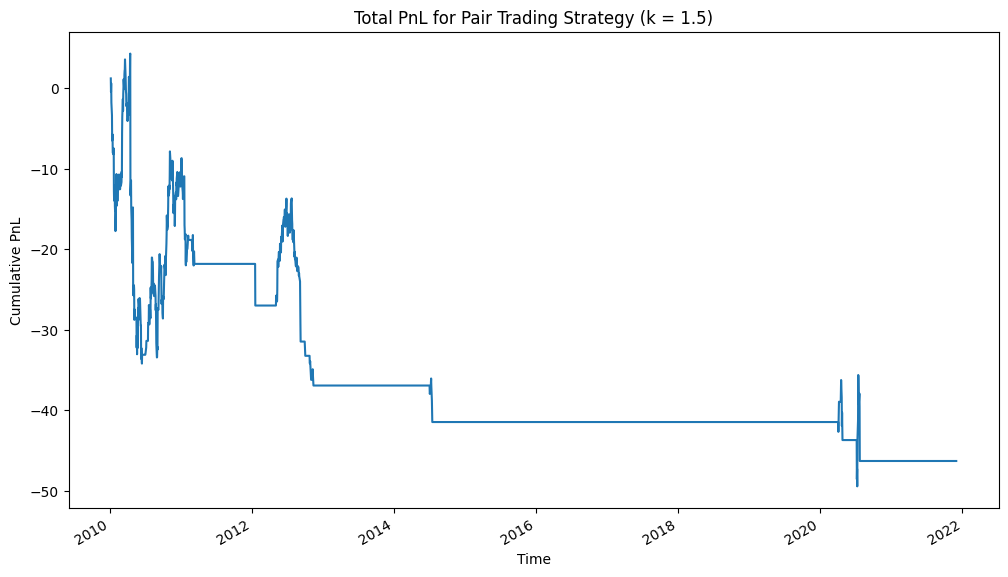

In [ ]:
# Visualize the total PnL
total_pnl.cumsum().plot(figsize=(12, 7))
plt.title("Total PnL for Pair Trading Strategy (k = 1.5)")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.show()

b. Try the strategy to the pair that have the second highest correlation.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import yfinance as yf
from statsmodels.tsa.stattools import coint

# Function to calculate the z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.02:   # we choose p-value level at 2%
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

# Load data
tickers = ["JPM", "BAC", "C", "WFC", "GS", "MS", "USB", "TFC", "PNC", "COF"]
start_date = "2010-01-01"
end_date = "2021-12-01"
data = yf.download(tickers, start_date, end_date)["Adj Close"].dropna()

# Find cointegrated pairs
pvalues, pairs = find_cointegrated_pairs(data)
print("Cointegrated Pairs:", pairs)

# Sort the pairs based on the p-values in ascending order
pairs.sort(key=lambda x: pvalues[tickers.index(x[0]), tickers.index(x[1])])

# Check if there are at least two pairs with significant correlation
if len(pairs) >= 2:
    # Get the pair with the second highest cointegration (lowest p-value) [Index 1]
    second_highest_correlation_pair = pairs[1]
    symbol1_prices = data[second_highest_correlation_pair[0]]
    symbol2_prices = data[second_highest_correlation_pair[1]]

    # Calculate the price ratio
    ratios = symbol1_prices / symbol2_prices

    # Calculate the z-score
    z_scores = zscore(ratios)

    # Define the threshold 'k'
    k = 1.5

    # Generate buy and sell signals
    symbol1_buy = pd.Series(0, index=symbol1_prices.index)
    symbol1_sell = pd.Series(0, index=symbol1_prices.index)
    symbol2_buy = pd.Series(0, index=symbol2_prices.index)
    symbol2_sell = pd.Series(0, index=symbol2_prices.index)

    symbol1_buy[z_scores > k] = 1
    symbol1_sell[z_scores < -k] = 1
    symbol2_buy[z_scores < -k] = 1
    symbol2_sell[z_scores > k] = 1

    # Calculate the positions for Symbol 1 and Symbol 2
    symbol1_positions = symbol1_buy - symbol1_sell
    symbol2_positions = symbol2_buy - symbol2_sell

    # Calculate the PnL for each trading position
    symbol1_pnl = symbol1_positions.shift(1) * (symbol1_prices - symbol1_prices.shift(1))
    symbol2_pnl = symbol2_positions.shift(1) * (symbol2_prices - symbol2_prices.shift(1))

    # Calculate the total PnL
    total_pnl = symbol1_pnl + symbol2_pnl

    # Visualize the total PnL
    total_pnl.cumsum().plot(figsize=(12, 7))
    plt.title("Total PnL for Pair Trading Strategy (k = 1.5) - Second Highest Correlation Pair")
    plt.xlabel("Time")
    plt.ylabel("Cumulative PnL")
    plt.show()
else:
    print("Insufficient cointegrated pairs to proceed with the second highest correlation pair.")



[*********************100%***********************]  10 of 10 completed
Cointegrated Pairs: [('COF', 'GS')]
Insufficient cointegrated pairs to proceed with the second highest correlation pair.


Question 2: We discussed the statistical arbitrage strategy in class. The program is attached to this assignment, and notes are added to explain the ideas behind the strategy. In this question, you are asked to use ML to generate the trading condition. More specifically,

c. Download the historical data (2010-2021) for the 6 currency pairs, and choose one as the trading instrument.

d. Use the 2010-2020 data for training. One each day, use the closing price for the 5 pairs of currency( exclude the trading instrument you have chosen) to predict the closing price of the trading instrument (5 features, the target variable is the closing price of the trading instrument). You can choose any ML program you like.

e. Implement a trading strategy similar to StatArb for year 2022. The reading signal is generated in the following way: on each day, if your ML predicted price is higher than the actual closing price( by a certain threshold), it is a buy signal: if the predicted price is lower than the actual closing price by a certain threshold, you should short.

Starting with part c

c. Download the historical data (2010-2021) for the 6 currency pairs, and choose one as the trading instrument.

In [ ]:
import pandas as pd
import yfinance as yf

# Constants
TRADING_INSTRUMENT = 'CADUSD=X'
SYMBOLS = ['AUDUSD=X', 'GBPUSD=X', 'CADUSD=X', 'CHFUSD=X', 'EURUSD=X', 'JPYUSD=X', 'NZDUSD=X']
START_DATE = '2010-01-01'
END_DATE = '2021-12-31'

# Download historical data for each currency pair
symbols_data = {}
for symbol in SYMBOLS:
    data_orig = yf.download(symbol, START_DATE, END_DATE)
    symbols_data[symbol] = data_orig

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


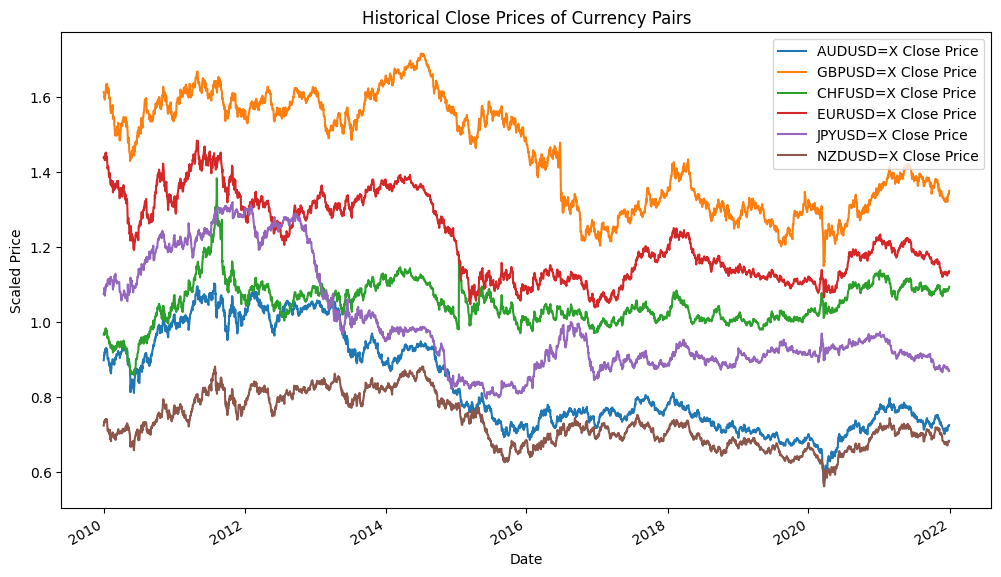

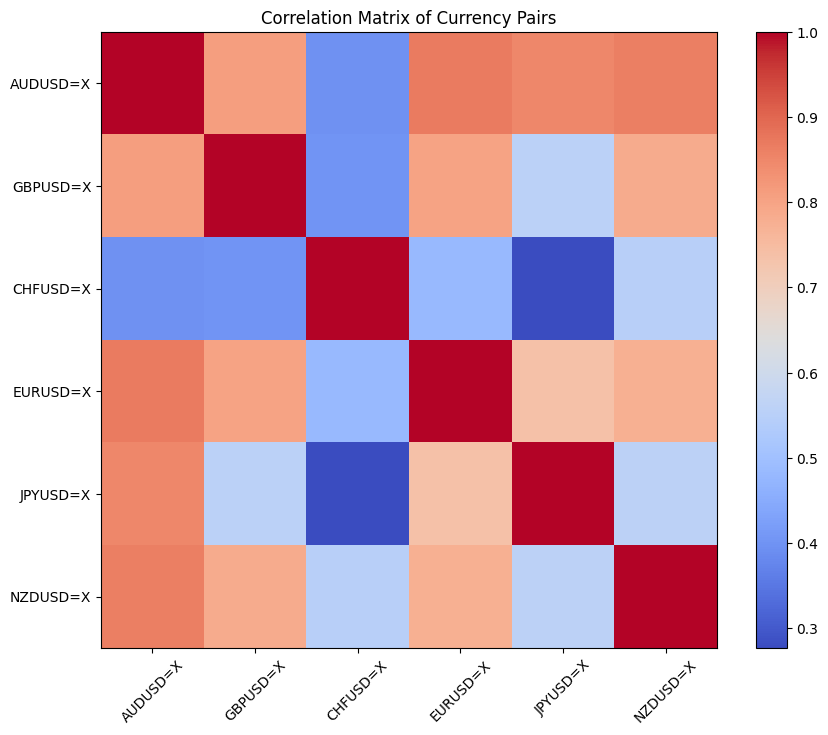

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# Plot historical prices for each currency pair
cycol = cycle('bgrcmky')  # Cycle through colors

price_data = pd.DataFrame()
for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:
        continue
    multiplier = 1.0
    if symbol == 'JPYUSD=X':
        multiplier = 100.0
    elif symbol == 'CNYUSD=X':
        multiplier = 10.0

    label = symbol + ' Close Price'
    price_data[label] = symbols_data[symbol]['Close'] * multiplier

price_data.plot(figsize=(12, 7))
plt.title("Historical Close Prices of Currency Pairs")
plt.xlabel("Date")
plt.ylabel("Scaled Price")
plt.legend(prop={'size': 10})
plt.show()

# Calculate and visualize the correlation matrix
correlation_matrix = price_data.corr()
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(SYMBOLS) - 1), [s for s in SYMBOLS if s != TRADING_INSTRUMENT], rotation=45)
plt.yticks(np.arange(len(SYMBOLS) - 1), [s for s in SYMBOLS if s != TRADING_INSTRUMENT])
plt.title("Correlation Matrix of Currency Pairs")
plt.show()



d. Use the 2010-2020 data for training. One each day, use the closing price for the 5 pairs of currency( exclude the trading instrument you have chosen) to predict the closing price of the trading instrument (5 features, the target variable is the closing price of the trading instrument). You can choose any ML program you like.

Mean Squared Error: 0.0007910461813514737


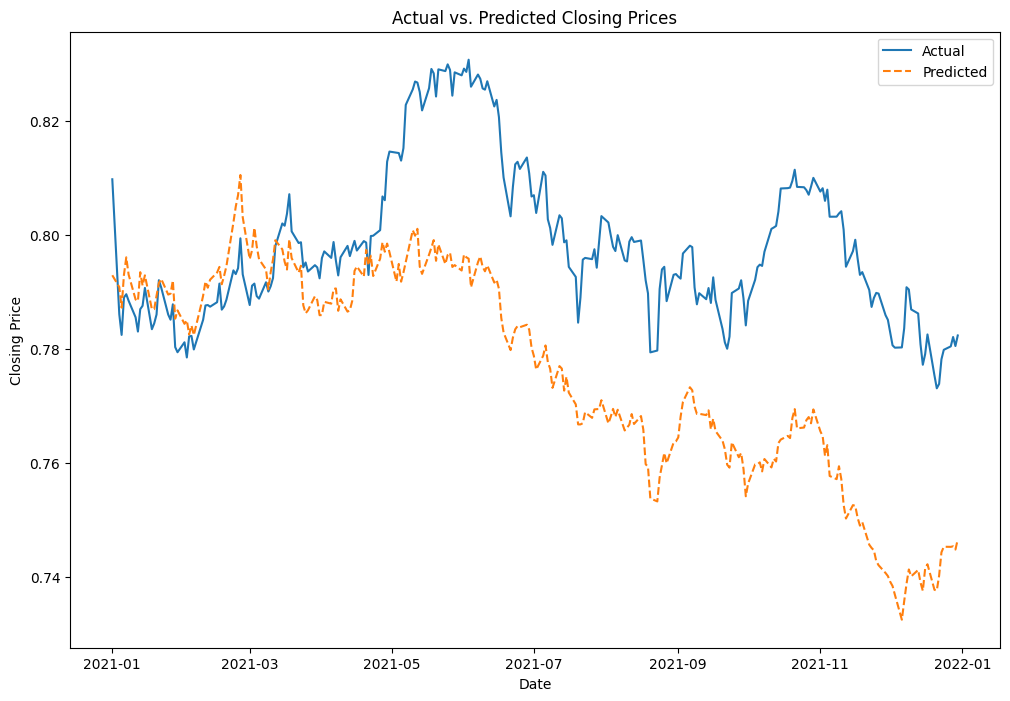

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Load historical data for all currency pairs
# Make sure you have loaded and processed the data as before

# Exclude the trading instrument from the feature set
feature_symbols = [s for s in SYMBOLS if s != TRADING_INSTRUMENT]
features = pd.DataFrame()

for symbol in feature_symbols:
    features[symbol] = symbols_data[symbol]['Close']

target = symbols_data[TRADING_INSTRUMENT]['Close']

# Split data into training (2010-2020) and testing (2021)
train_start = '2010-01-01'
train_end = '2020-12-31'
test_start = '2021-01-01'
test_end = '2021-12-31'

train_features = features.loc[train_start:train_end]
train_target = target.loc[train_start:train_end]
test_features = features.loc[test_start:test_end]
test_target = target.loc[test_start:test_end]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
train_features_imputed = imputer.fit_transform(train_features)
test_features_imputed = imputer.transform(test_features)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(train_features_imputed, train_target)

# Make predictions on the testing data
predictions = model.predict(test_features_imputed)

# Calculate Mean Squared Error to evaluate the model
mse = mean_squared_error(test_target, predictions)
print(f"Mean Squared Error: {mse}")

# Visualize the actual vs. predicted prices
plt.plot(test_target.index, test_target, label="Actual")
plt.plot(test_target.index, predictions, label="Predicted", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs. Predicted Closing Prices")
plt.legend()
plt.show()



e. Implement a trading strategy similar to StatArb for year 2022. The reading signal is generated in the following way: on each day, if your ML predicted price is higher than the actual closing price( by a certain threshold), it is a buy signal: if the predicted price is lower than the actual closing price by a certain threshold, you should short.

In [ ]:
# Define the minimum profit to close a position
MIN_PROFIT_TO_CLOSE = 10

# Use the model to make predictions on the test features for 2022
predictions_2022 = model.predict(test_features_imputed)

# Define the buy and short thresholds
buy_threshold = 0.01  # Adjust this threshold as needed
short_threshold = -0.01  # Adjust this threshold as needed

# Initialize variables for trading positions and profits
position = 0  # 0 for flat, +1 for long, -1 for short
capital = 1000000  # Starting capital
buy_price = 0
short_price = 0
profits = []

# Iterate through each day in 2022
for i in range(len(test_target)):
    predicted_price = predictions_2022[i]
    actual_price = test_target.iloc[i]

    # Check if the predicted price is higher than the actual price by the buy threshold
    if predicted_price > actual_price * (1 + buy_threshold):
        if position == 0:
            position = 1  # Buy
            buy_price = actual_price
            print(f"Buy at {actual_price}")
    # Check if the predicted price is lower than the actual price by the short threshold
    elif predicted_price < actual_price * (1 - short_threshold):
        if position == 0:
            position = -1  # Short
            short_price = actual_price
            print(f"Short at {actual_price}")

    # Close the position if it's profitable enough
    if position == 1 and actual_price - buy_price >= MIN_PROFIT_TO_CLOSE:
        profits.append(actual_price - buy_price)
        capital += actual_price - buy_price
        position = 0
        print(f"Close long at {actual_price}")
    elif position == -1 and short_price - actual_price >= MIN_PROFIT_TO_CLOSE:
        profits.append(short_price - actual_price)
        capital += short_price - actual_price
        position = 0
        print(f"Close short at {actual_price}")

# Calculate and print the final capital and profits
final_capital = capital + position * test_target.iloc[-1]
total_profit = sum(profits)
print(f"Final Capital: {final_capital}")
print(f"Total Profit: {total_profit}")


Short at 0.8097231388092041
Final Capital: 999999.2176865339
Total Profit: 0


Question 3: Based on the past 60 business day historical prices, classify the S&P500 companies (i.e., the companies that are currently included in the S&P500 index). You can use Kmeans, hierachical clustering, Affinity Propogation, or any other models.

a. What is the optimal number of clusters?

b. Through visualization and correlation, discuss the common features among the stocks in each group.




In [ ]:
import bs4 as bs
import requests
import yfinance as yf
import datetime

In [ ]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [ ]:
tickers = []

for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

In [ ]:
print(tickers)

['MMM\n', 'AOS\n', 'ABT\n', 'ABBV\n', 'ACN\n', 'ATVI\n', 'ADM\n', 'ADBE\n', 'ADP\n', 'AAP\n', 'AES\n', 'AFL\n', 'A\n', 'APD\n', 'AKAM\n', 'ALK\n', 'ALB\n', 'ARE\n', 'ALGN\n', 'ALLE\n', 'LNT\n', 'ALL\n', 'GOOGL\n', 'GOOG\n', 'MO\n', 'AMZN\n', 'AMCR\n', 'AMD\n', 'AEE\n', 'AAL\n', 'AEP\n', 'AXP\n', 'AIG\n', 'AMT\n', 'AWK\n', 'AMP\n', 'ABC\n', 'AME\n', 'AMGN\n', 'APH\n', 'ADI\n', 'ANSS\n', 'AON\n', 'APA\n', 'AAPL\n', 'AMAT\n', 'APTV\n', 'ACGL\n', 'ANET\n', 'AJG\n', 'AIZ\n', 'T\n', 'ATO\n', 'ADSK\n', 'AZO\n', 'AVB\n', 'AVY\n', 'AXON\n', 'BKR\n', 'BALL\n', 'BAC\n', 'BBWI\n', 'BAX\n', 'BDX\n', 'WRB\n', 'BRK.B\n', 'BBY\n', 'BIO\n', 'TECH\n', 'BIIB\n', 'BLK\n', 'BK\n', 'BA\n', 'BKNG\n', 'BWA\n', 'BXP\n', 'BSX\n', 'BMY\n', 'AVGO\n', 'BR\n', 'BRO\n', 'BF.B\n', 'BG\n', 'CHRW\n', 'CDNS\n', 'CZR\n', 'CPT\n', 'CPB\n', 'COF\n', 'CAH\n', 'KMX\n', 'CCL\n', 'CARR\n', 'CTLT\n', 'CAT\n', 'CBOE\n', 'CBRE\n', 'CDW\n', 'CE\n', 'CNC\n', 'CNP\n', 'CDAY\n', 'CF\n', 'CRL\n', 'SCHW\n', 'CHTR\n', 'CVX\n', 'CMG\n', 

In [ ]:
tickers = [s.replace('\n', '') for s in tickers]

In [ ]:
print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'C

In [ ]:
# Specify the date range for historical data (past 60 business days)
end_date = datetime.datetime.today().date()
start_date = end_date - pd.DateOffset(days=60)

# Download historical price data for each ticker
price_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Remove columns with missing data
price_data.dropna(axis=1, inplace=True)

# Calculate daily returns
returns_data = price_data.pct_change().dropna()

returns_data.head()

[*********************100%***********************]  503 of 503 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-06-03 00:00:00 -> 2023-08-02)')
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-06 00:00:00,-0.007689,0.008103,0.007318,-0.002060,-0.010449,-0.001832,-0.010987,-0.001403,0.011792,-0.002971,...,0.021577,-0.006099,0.008168,0.005396,0.001225,-0.009615,-0.001533,0.003679,0.048747,-0.005727
2023-06-07 00:00:00,-0.007238,0.015405,-0.008022,-0.007756,0.007901,-0.004531,-0.009355,0.000702,0.009707,-0.033658,...,0.005061,0.011800,0.022421,0.006644,0.007433,-0.003311,0.021494,0.027619,0.045485,-0.038557
2023-06-08 00:00:00,-0.016296,0.009235,-0.012206,0.015465,0.008352,0.016534,-0.008656,-0.003649,-0.011896,0.049508,...,-0.001937,-0.002643,-0.003133,-0.017263,0.018397,0.005738,0.016683,0.001693,0.016513,0.004402
2023-06-09 00:00:00,0.009591,0.017647,-0.017918,0.002160,0.003923,0.010031,0.009030,0.006339,0.004523,0.034098,...,-0.008248,-0.010758,-0.007394,-0.007492,0.006052,0.001802,0.005322,-0.012121,-0.035614,-0.007365
2023-06-12 00:00:00,0.023750,0.028902,0.052060,0.015639,-0.003257,0.006172,-0.002852,-0.013858,0.008940,0.045441,...,0.013404,0.001891,-0.009033,0.007288,-0.008112,0.008918,-0.003382,0.019406,-0.020408,0.015084


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

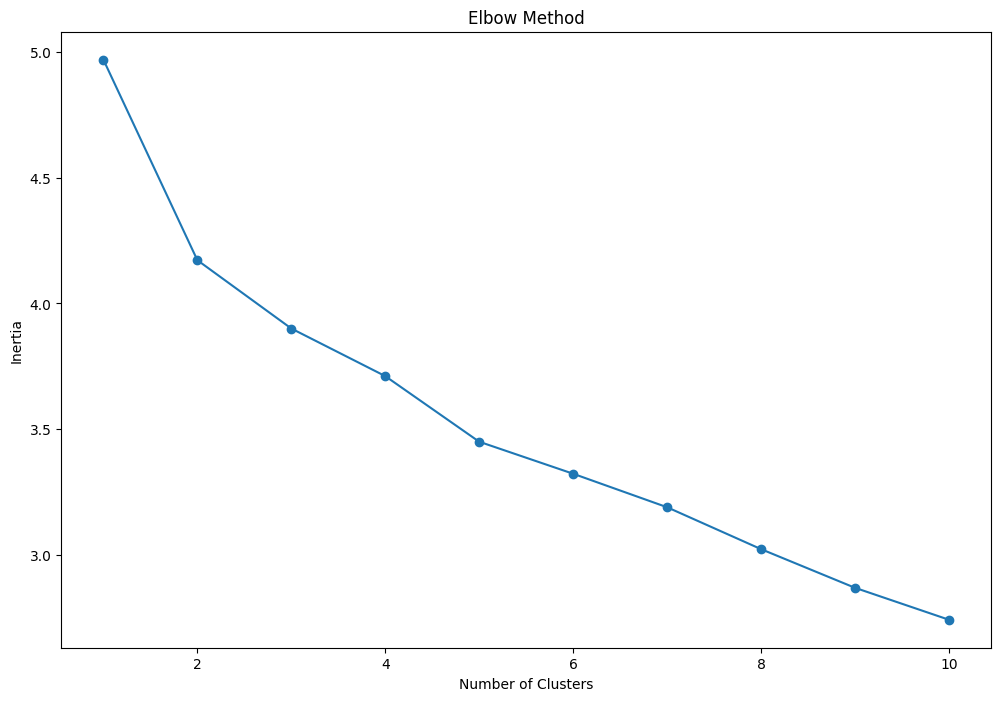

The optimal number of clusters is: 2


In [ ]:
#Clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate sum of squared distances (inertia) for different number of clusters
inertia = []
for num_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(returns_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Determine the optimal number of clusters based on the Elbow Method
optimal_clusters = None
for i in range(1, len(inertia) - 1):
    elbow_diff = inertia[i] - inertia[i + 1]
    if elbow_diff < 0.1 * inertia[i]:
        optimal_clusters = i + 1
        break

if optimal_clusters is not None:
    print(f"The optimal number of clusters is: {optimal_clusters}")
else:
    print("Optimal number of clusters not found using the Elbow Method.")


b. Through visualization and correlation, discuss the common features among the stocks in each group.

In [ ]:
import bs4 as bs
import requests
import yfinance as yf
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Scraping S&P500 tickers from Wikipedia
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker.strip())

# Define a time range for historical data
end_date = datetime.datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.datetime.today() - datetime.timedelta(days=60)).strftime('%Y-%m-%d')



# Download historical stock data using yfinance
returns_data = pd.DataFrame()  # Create an empty DataFrame for returns data

for ticker in tickers:
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
        returns_data[ticker] = stock_data.pct_change().dropna()
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Preprocess the data to handle missing or infinite values
returns_data.fillna(0, inplace=True)  # Fill missing values with 0
returns_data.replace([np.inf, -np.inf], 0, inplace=True)  # Replace infinite values with 0



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-06-03 -> 2023-08-02)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()



[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()



[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()



[*********************100%***********************]  1 of 1 completed

<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()



[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()



[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()
<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


<ipython-input-29-7337856f0402>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_data[ticker] = stock_data.pct_change().dropna()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


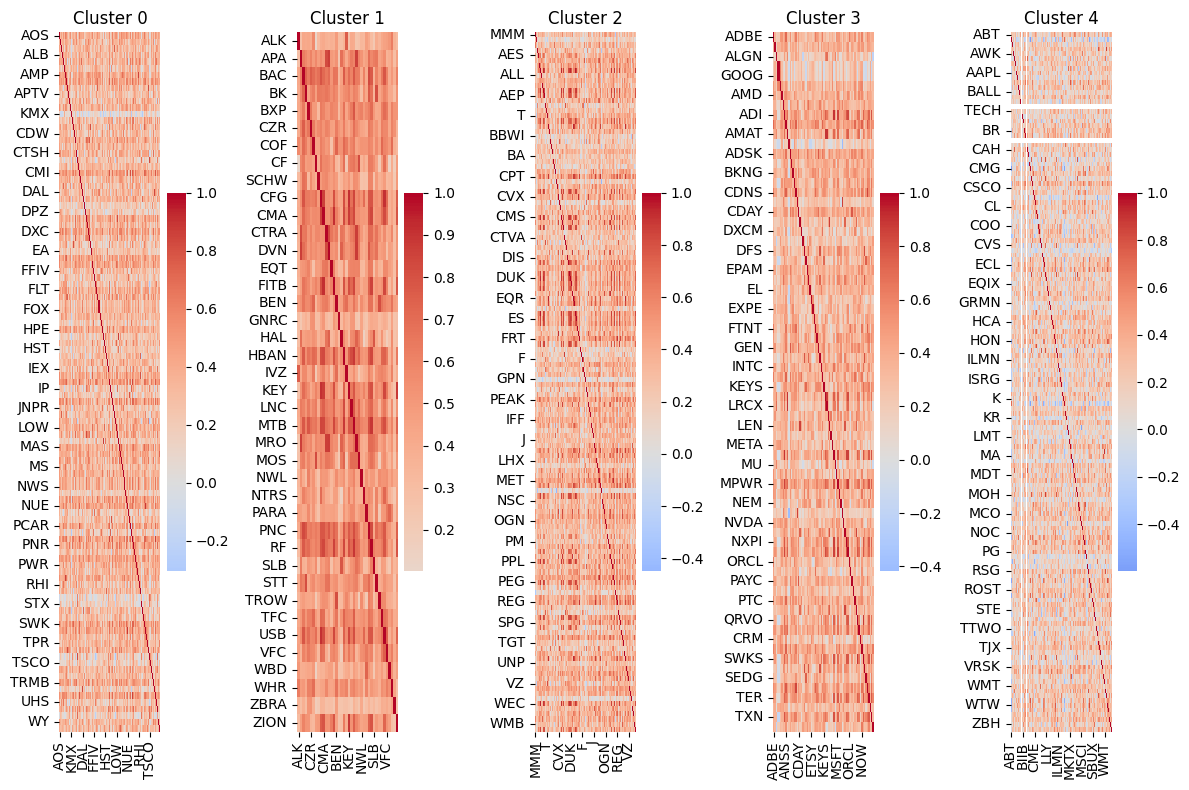

In [95]:

# Perform clustering (KMeans in this example)
num_clusters = 5  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters)
cluster_assignments = kmeans.fit_predict(returns_data.T)  # Transpose returns_data

# Create a DataFrame with tickers and cluster assignments
clustered_stocks = pd.DataFrame({'Ticker': tickers, 'Cluster': cluster_assignments})

# Calculate correlation matrices for each cluster
cluster_correlation_matrices = []
for cluster_id in range(num_clusters):
    stocks_in_cluster = clustered_stocks[clustered_stocks['Cluster'] == cluster_id]['Ticker']
    cluster_data = returns_data[stocks_in_cluster]
    cluster_correlation_matrix = cluster_data.corr()
    cluster_correlation_matrices.append(cluster_correlation_matrix)

# Visualize correlation matrices for each cluster using heatmaps
plt.figure(figsize=(12, 8))
for cluster_id, correlation_matrix in enumerate(cluster_correlation_matrices):
    plt.subplot(1, num_clusters, cluster_id + 1)
    sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
    plt.title(f'Cluster {cluster_id}')
plt.tight_layout()
plt.show()


Question 4. Choose a stock you like, and repeat the trading strategy in the program BitcoinTradingStrategy.ipynb

You need to make the following adjustments.

1. Use the past 4 years historical price
2. For the moving average, use 5 days, 20 days and 50 days.
3. For the trading signal, you can first repeat the one used in the program ( having _1 share in your portfolio if first moving average > slow moving and -1 share otherwise). You should also design a trading signal on your own(e.g + 1 share if next days proce > todays proce, -1 otherwise) and repeat the approach in the program.
4. In addition to the "engineered" features using the historical stock price, you should also include an index, e.g. s&p 500 ( just the index itself, not the index MA)
5. In addition to the models used in the program, you should also try some deep learning models such as LSTM.

In [96]:
#Starting with point 1


1. Use the past 4 years historical price

In [97]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Download AMZN historical data for the past 4 years
amzn_data = yf.download('AMZN', start='2017-08-02', end='2021-08-02')

[*********************100%***********************]  1 of 1 completed


In [ ]:
#downloaded the historical data for the past 4 years

2. For the moving average, use 5 days, 20 days and 50 days.

In [99]:
# Calculate moving averages for 5 days, 20 days, and 50 days
amzn_data['MA5'] = amzn_data['Close'].rolling(window=5).mean()
amzn_data['MA20'] = amzn_data['Close'].rolling(window=20).mean()
amzn_data['MA50'] = amzn_data['Close'].rolling(window=50).mean()

# Print the updated DataFrame
print(amzn_data[['Close', 'MA5', 'MA20', 'MA50']].tail())


                 Close         MA5        MA20        MA50
Date                                                      
2021-07-26  184.990997  181.528799  180.210249  171.472379
2021-07-27  181.319504  182.060800  180.666499  171.875869
2021-07-28  181.516006  182.512003  181.121950  172.235799
2021-07-29  179.996002  182.130902  181.521350  172.603439
2021-07-30  166.379501  178.840402  181.257900  172.699229


3. For the trading signal, you can first repeat the one used in the program ( having _1 share in your portfolio if first moving average > slow moving and -1 share otherwise). You should also design a trading signal on your own(e.g + 1 share if next days price > todays price, -1 otherwise) and repeat the approach in the program.

In [100]:
# Calculate the trading signal based on moving averages crossover
amzn_data['Original_Signal'] = np.where(amzn_data['MA5'] > amzn_data['MA50'], 1, -1)

# Print the updated DataFrame
print(amzn_data[['Close', 'MA5', 'MA50', 'Original_Signal']].tail())


                 Close         MA5        MA50  Original_Signal
Date                                                           
2021-07-26  184.990997  181.528799  171.472379                1
2021-07-27  181.319504  182.060800  171.875869                1
2021-07-28  181.516006  182.512003  172.235799                1
2021-07-29  179.996002  182.130902  172.603439                1
2021-07-30  166.379501  178.840402  172.699229                1


In [101]:
# Calculate the new trading signal based on next day's price comparison
amzn_data['New_Signal'] = np.where(amzn_data['Close'].shift(-1) > amzn_data['Close'], 1, -1)

# Print the updated DataFrame
print(amzn_data[['Close', 'New_Signal']].tail())


                 Close  New_Signal
Date                              
2021-07-26  184.990997          -1
2021-07-27  181.319504           1
2021-07-28  181.516006          -1
2021-07-29  179.996002          -1
2021-07-30  166.379501          -1


4.In addition to the "engineered" features using the historical stock price, you should also include an index, e.g. s&p 500 ( just the index itself, not the index MA)

In [103]:
import yfinance as yf

# Define the ticker symbol for S&P 500 index
sp500_ticker = '^GSPC'  # ^GSPC is the ticker symbol for S&P 500 index

# Define the start and end dates to match the amzn_data date range
start_date = '2017-08-02'
end_date = '2021-08-02'

# Download historical data for S&P 500 index
sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date)

# Print the downloaded data
sp500_data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-02,2480.379883,2480.379883,2466.479980,2477.570068,2477.570068,3487150000
2017-08-03,2476.030029,2476.030029,2468.850098,2472.159912,2472.159912,3662410000
2017-08-04,2476.879883,2480.000000,2472.080078,2476.830078,2476.830078,3239980000
2017-08-07,2477.139893,2480.949951,2475.879883,2480.909912,2480.909912,2935130000
2017-08-08,2478.350098,2490.870117,2470.320068,2474.919922,2474.919922,3347480000


In [104]:
# Merge the two DataFrames based on their date indices
combined_data = amzn_data.merge(sp500_data['Adj Close'], left_index=True, right_index=True, suffixes=('_AMZN', '_SP500'))


In [105]:
combined_data.head()

,Open,High,Low,Close,Adj Close_AMZN,Volume,short_mavg,long_mavg,signal_original,signal_custom,Adj Close_SP500,MA5,MA20,MA50,Original_Signal,New_Signal,Adj Close
Date,,,,,,,,,,,,,,,,,
2017-08-02,50.088501,50.160500,49.086498,49.794498,49.794498,81400000,49.794498,49.794498,-1.0,-1.0,2477.570068,NaN,NaN,NaN,-1,-1,2477.570068
2017-08-03,49.973499,49.974998,49.229500,49.346001,49.346001,65116000,49.570250,49.570250,-1.0,1.0,2472.159912,NaN,NaN,NaN,-1,1,2472.159912
2017-08-04,49.484001,49.583500,49.099998,49.379002,49.379002,54606000,49.506500,49.506500,-1.0,1.0,2476.830078,NaN,NaN,NaN,-1,1,2476.830078
2017-08-07,49.532501,49.750000,49.356998,49.613499,49.613499,53532000,49.533250,49.533250,-1.0,-1.0,2480.909912,NaN,NaN,NaN,-1,-1,2480.909912
2017-08-08,49.717499,49.813999,49.289501,49.492001,49.492001,58056000,49.525000,49.525000,-1.0,-1.0,2474.919922,49.525,NaN,NaN,-1,-1,2474.919922


5. In addition to the models used in the program, you should also try some deep learning models such as LSTM.

In [108]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load and preprocess data
amzn_data = yf.download('AMZN', start='2017-08-02', end='2021-08-02')
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(amzn_data['Adj Close'].values.reshape(-1, 1))

# Create sequences for LSTM
sequence_length = 10
sequences = []
labels = []
for i in range(sequence_length, len(scaled_data)):
    sequences.append(scaled_data[i - sequence_length:i, 0])
    labels.append(scaled_data[i, 0])
sequences = np.array(sequences)
labels = np.array(labels)

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)
train_sequences = sequences[:split_index]
train_labels = labels[:split_index]
test_sequences = sequences[split_index:]
test_labels = labels[split_index:]

# Build and train LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_sequences.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_sequences, train_labels, epochs=10, batch_size=32)

# Evaluate the model
predicted_prices = model.predict(test_sequences)
predicted_prices = scaler.inverse_transform(predicted_prices)
test_labels = scaler.inverse_transform(test_labels.reshape(-1, 1))



[*********************100%***********************]  1 of 1 completed
Epoch 1/10
25/25 [==============================] - 7s 15ms/step - loss: 0.0349
Epoch 2/10
25/25 [==============================] - 0s 15ms/step - loss: 0.0028
Epoch 3/10
25/25 [==============================] - 0s 16ms/step - loss: 9.4871e-04
Epoch 4/10
25/25 [==============================] - 0s 14ms/step - loss: 8.8483e-04
Epoch 5/10
25/25 [==============================] - 0s 15ms/step - loss: 8.6698e-04
Epoch 6/10
25/25 [==============================] - 0s 18ms/step - loss: 8.9993e-04
Epoch 7/10
25/25 [==============================] - 1s 25ms/step - loss: 8.4282e-04
Epoch 8/10
25/25 [==============================] - 1s 26ms/step - loss: 8.3291e-04
Epoch 9/10
25/25 [==============================] - 1s 23ms/step - loss: 8.2318e-04
Epoch 10/10
7/7 [==============================] - 1s 5ms/step


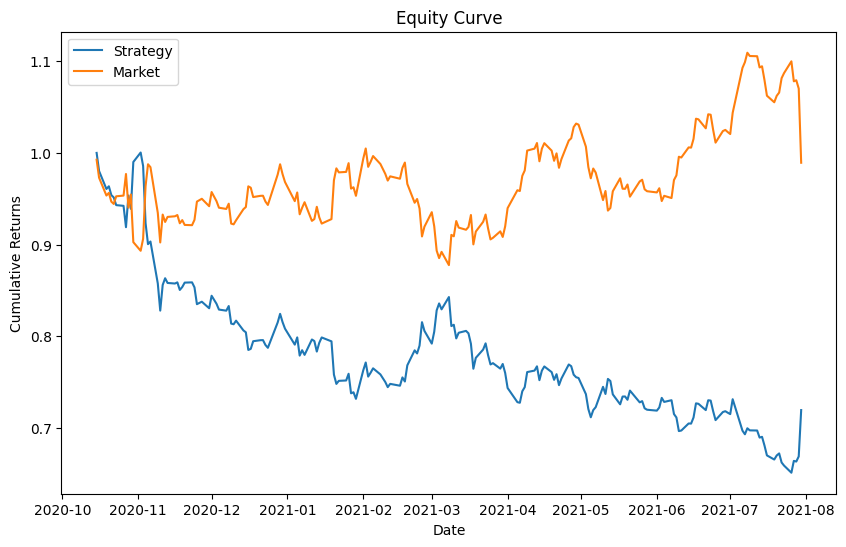

Total Strategy Return: -0.30051960640945974
Total Market Return: 0.018192552010778185
Sharpe Ratio: -0.09420521345954368
Max Drawdown: -0.34924090076702663


In [111]:
#Implementing the bitcoingtradingstrategy

# Define your trading logic here
def generate_signals(predicted_prices):
    signals = []
    for i in range(len(predicted_prices)):
        if i == 0:
            signals.append(0)  # No signal on the first day
        else:
            if predicted_prices[i] > predicted_prices[i - 1]:
                signals.append(1)  # Buy signal
            else:
                signals.append(-1)  # Sell signal
    return signals

# Implement trading strategy on LSTM predicted prices
predicted_prices = predicted_prices.flatten()  # Flatten the predicted prices array
signals = generate_signals(predicted_prices)
backtest_data = pd.DataFrame(index=amzn_data.index[split_index + sequence_length:])
backtest_data['predicted_prices'] = predicted_prices
backtest_data['signal'] = signals
backtest_data['Market Returns'] = amzn_data.loc[backtest_data.index, 'Adj Close'].pct_change()
backtest_data['Strategy Returns'] = backtest_data['Market Returns'] * backtest_data['signal'].shift(1)
backtest_data['Cumulative Strategy Returns'] = (1 + backtest_data['Strategy Returns']).cumprod()
backtest_data['Cumulative Market Returns'] = (1 + backtest_data['Market Returns']).cumprod()

# Plot equity curve
plt.figure(figsize=(10, 6))
plt.plot(backtest_data['Cumulative Strategy Returns'], label='Strategy')
plt.plot(backtest_data['Cumulative Market Returns'], label='Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Equity Curve')
plt.legend()
plt.show()

# Calculate and print performance metrics (similar to Random Forest approach)
total_strategy_return = backtest_data['Strategy Returns'].sum()
total_market_return = backtest_data['Market Returns'].sum()
sharpe_ratio = (backtest_data['Strategy Returns'].mean() - backtest_data['Market Returns'].mean()) / backtest_data['Strategy Returns'].std()
max_drawdown = (backtest_data['Cumulative Strategy Returns'] / backtest_data['Cumulative Strategy Returns'].cummax() - 1).min()

print('Total Strategy Return:', total_strategy_return)
print('Total Market Return:', total_market_return)
print('Sharpe Ratio:', sharpe_ratio)
print('Max Drawdown:', max_drawdown)

